# Import Libraries

In [143]:
import pandas as pd
import numpy as np
import re
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from gensim.models import Word2Vec, FastText
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from gensim.models import FastText, Word2Vec
import gensim.downloader as api

In [144]:
nltk.download('punkt_tab' ,quiet=True)
nltk.download('stopwords',quiet=True)

True

In [145]:
data = pd.read_csv('Tweets.csv')

## Getting to know the data

In [146]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [147]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Clean the text

In [148]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Download stopwords and tokenizer if not already downloaded
nltk.download('stopwords')
nltk.download('punkt')

# Define stop words in English
stop_words = set(stopwords.words('english'))


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/vanlian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/vanlian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [149]:
def clean_text(text):
    if pd.isna(text):
        return ""
    # Convert to lowercase
    text = text.lower()
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove @mentions
    text = re.sub(r'@\w+', '', text)
    # Remove hashtags (keep the text)
    text = re.sub(r'#', '', text)
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Apply to the 'text' column
data['clean_text'] = data['text'].apply(clean_text)


In [150]:
data.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone,clean_text
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada),what said.
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada),plus you've added commercials to the experienc...
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada),i didn't today... must mean i need to take ano...
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada),"it's really aggressive to blast obnoxious ""ent..."
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada),and it's a really big bad thing about it


## EDA

In [151]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count of each sentiment class
class_counts = data['airline_sentiment'].value_counts()

print("Class Distribution:")
print(class_counts)

# Percentage
print("\nPercentage Distribution:")
print((class_counts / len(data) * 100).round(2))


Class Distribution:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

Percentage Distribution:
airline_sentiment
negative    62.69
neutral     21.17
positive    16.14
Name: count, dtype: float64


/tmp/ipykernel_125610/304725497.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='airline_sentiment', data=data, palette='viridis')


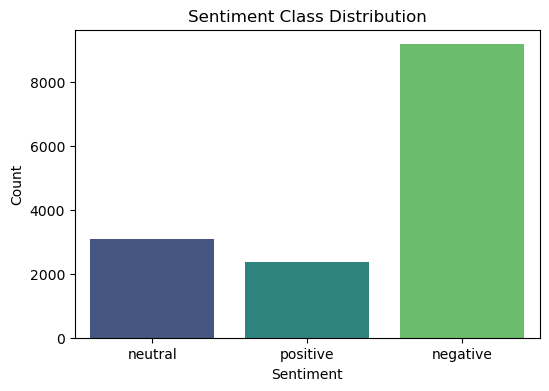

In [152]:
plt.figure(figsize=(6,4))
sns.countplot(x='airline_sentiment', data=data, palette='viridis')
plt.title("Sentiment Class Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


Karna datanya classnya imbalance maka kita akan lakukan balancing setelah melakukan text representation

## Embedding

In [ ]:
def preprocess_for_embeddings(texts):
    # Prepare tokenized text list for Word2Vec / FastText embeddings.
    X_tokens_for_embedding = []
    for text in texts:
        text = re.sub(r'https?://\S+|www\.\S+', '', str(text))
        text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
        tokens = word_tokenize(text)
        tokens = [w for w in tokens if w not in stop_words and len(w) > 1]
        X_tokens_for_embedding.append(tokens)
    return X_tokens_for_embedding

In [154]:
X = data['clean_text']
y = data['airline_sentiment']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("\nTrain/Test sizes:", len(X_train), "|", len(X_test))


Train/Test sizes: 11712 | 2928


In [155]:
X_train_tokens = preprocess_for_embeddings(X_train)
X_test_tokens  = preprocess_for_embeddings(X_test)

## BoW (Bag of Words)


In [156]:
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_features=8000)
X_bow = bow_vectorizer.fit_transform(data['clean_text'])

print("BoW shape:", X_bow.shape)


BoW shape: (14640, 8000)


## TF - IDF (TfidfVectorizer)

In [157]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_features=8000)
X_tfidf = tfidf_vectorizer.fit_transform(data['clean_text'])

print("TF-IDF shape:", X_tfidf.shape)


TF-IDF shape: (14640, 8000)


## Word2Vec



In [158]:
# Word2Vec
print('Training Word2Vec...')
w2v_model = Word2Vec(sentences=X_train_tokens , vector_size=100, window=5, min_count=2, workers=4)


Training Word2Vec...


In [159]:
# Rata-rata vektor kata per dokumen
def avg_vector(tokens, model):
    vectors = [model.wv[word] for word in tokens if word in model.wv]
    if len(vectors) == 0:
        return np.zeros(model.vector_size)
    return np.mean(vectors, axis=0)

In [160]:
#CONVERT TEXT TO VECTORS
# Representasi dokumen rata-rata embedding
X_train_w2v = np.array([avg_vector(t, w2v_model) for t in X_train_tokens])
X_test_w2v  = np.array([avg_vector(t, w2v_model) for t in X_test_tokens])


print("Shape X_train Word2Vec:", X_train_w2v.shape)
print("Jumlah kata unik di Word2Vec:", len(w2v_model.wv))
print("Beberapa vocab:", list(w2v_model.wv.key_to_index.keys())[:20])


Shape X_train Word2Vec: (11712, 100)
Jumlah kata unik di Word2Vec: 4985
Beberapa vocab: ['flight', 'get', 'thanks', 'cancelled', 'service', 'help', 'im', 'time', 'customer', 'us', 'hours', 'flights', 'amp', 'hold', 'plane', 'thank', 'cant', 'please', 'still', 'one']


## GloVe

In [161]:
import gensim.downloader as api
glove = api.load("glove-twitter-50")

In [162]:
def get_vector(tokens):
    # ambil hanya kata yang ada di vocab GloVe
    words = [w for w in tokens if w in glove]
    if not words:  # kalau tidak ada kata valid
        return np.zeros(glove.vector_size) ## kembalikan vektor nol
    # rata-rata semua vektor kata di kalimat
    return np.mean([glove[w] for w in words], axis=0)

# ubah seluruh data train dan test ke bentuk vektor
X_train_vec = np.array([get_vector(t) for t in X_train_tokens ])
X_test_vec  = np.array([get_vector(t) for t in X_test_tokens ])

In [163]:
print("\n===== GloVe =====")
print("Jumlah kata unik di GloVe:", len(glove))
print("Beberapa vocab:", list(glove.key_to_index.keys())[:20])



===== GloVe =====
Jumlah kata unik di GloVe: 1193514
Beberapa vocab: ['<user>', '.', ':', 'rt', ',', '<repeat>', '<hashtag>', '<number>', '<url>', '!', 'i', 'a', '"', 'the', '?', 'you', 'to', '(', '<allcaps>', '<elong>']


## FastText

In [164]:
print('\nTraining FastText...')
model_ft = FastText(sentences=X_train_tokens , vector_size=100, window=5, min_count=2, sg=1, workers=4, epochs=10 )
#model_ft.save("fasttext_airline.model")
ft = model_ft.wv

#CONVERT TEXT TO VECTORS
X_train_ft = np.array([avg_vector(t, model_ft) for t in X_train_tokens])
X_test_ft = np.array([avg_vector(t, model_ft) for t in X_test_tokens])


Training FastText...


In [165]:
print("\n===== FASTTEXT =====")
print("Jumlah kata unik di FastText:", len(model_ft.wv))
print("Beberapa vocab:", list(model_ft.wv.key_to_index.keys())[:20])


===== FASTTEXT =====
Jumlah kata unik di FastText: 4985
Beberapa vocab: ['flight', 'get', 'thanks', 'cancelled', 'service', 'help', 'im', 'time', 'customer', 'us', 'hours', 'flights', 'amp', 'hold', 'plane', 'thank', 'cant', 'please', 'still', 'one']


## Smote for Balancing

In [166]:
y = data['airline_sentiment']
print(y.value_counts())


airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64


Kita gunakan Smote sebagai tools for balancing data

In [167]:
from imblearn.over_sampling import SMOTE
import pandas as pd

# Convert sparse matrix → dense for SMOTE
X_tfidf_dense = X_tfidf.toarray()   # or use X_bow.toarray()

smote = SMOTE(random_state=42)
X_bal, y_bal = smote.fit_resample(X_tfidf_dense, y)

print("Before SMOTE:")
print(y.value_counts())

print("\nAfter SMOTE:")
print(pd.Series(y_bal).value_counts())


Before SMOTE:
airline_sentiment
negative    9178
neutral     3099
positive    2363
Name: count, dtype: int64

After SMOTE:
airline_sentiment
neutral     9178
positive    9178
negative    9178
Name: count, dtype: int64


Dengan menggunakan Smote kita dapat meng*balance* data kita yang dari imbalance menjadi balance dengan melakukan oversampling. Hasil dari melakukan Smote ini akan meningkatkan *fairness* model, agar model tidak bias ke kelas dengan kelas mayoritas.

In [169]:
from imblearn.pipeline import Pipeline

# Define the pipeline
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('rf', RandomForestClassifier(random_state=42, n_jobs=-1))
])


## Machine Learning Model


#### Random Forest 

In [173]:
# Parameter grid untuk tuning minimal 2 parameter
param_grid = {
    'rf__n_estimators': [100, 200, 300],     
    'rf__max_depth': [None, 10, 20, 30],     
    'rf__min_samples_split': [2, 5, 10],     
}

# Stratified 10-Fold Cross Validation
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring='accuracy',
    cv=cv,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_vec, y_train)

Fitting 10 folds for each of 36 candidates, totalling 360 fits
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=  14.3s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=  16.1s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=  16.3s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=  16.8s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=  16.9s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=  16.4s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=  17.2s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=  17.5s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total time=  17.6s
[CV] END rf__max_depth=None, rf__min_samples_split=2, rf__n_estimators=100; total 

,estimator,Pipeline(step...m_state=42))])
,param_grid,"{'rf__max_depth': [None, 10, ...], 'rf__min_samples_split': [2, 5, ...], 'rf__n_estimators': [100, 200, ...]}"
,scoring,'accuracy'
,n_jobs,-1
,refit,True
,cv,StratifiedKFo... shuffle=True)
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,sampling_strategy,'auto'


In [175]:
print("\n===== HASIL GRID SEARCH =====")
print("Best Parameters:", grid_search.best_params_)
print(f"Best Cross-Validation Accuracy: {grid_search.best_score_:.4f}")


===== HASIL GRID SEARCH =====
Best Parameters: {'rf__max_depth': 30, 'rf__min_samples_split': 2, 'rf__n_estimators': 300}
Best Cross-Validation Accuracy: 0.7438


In [176]:

best_rf = grid_search.best_estimator_

y_pred = best_rf.predict(X_test_vec)

print("\n===== EVALUASI PADA DATA TEST =====")
print(f"Accuracy on Test Set: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))


===== EVALUASI PADA DATA TEST =====
Accuracy on Test Set: 0.7503

Classification Report:
              precision    recall  f1-score   support

    negative       0.84      0.84      0.84      1835
     neutral       0.56      0.56      0.56       620
    positive       0.67      0.63      0.65       473

    accuracy                           0.75      2928
   macro avg       0.69      0.68      0.68      2928
weighted avg       0.75      0.75      0.75      2928


Confusion Matrix:
[[1550  193   92]
 [ 216  347   57]
 [  90   83  300]]


## Questions: representasi teks mana yang paling efektif untuk data tweet dan mengapa? Analisis juga pengaruh handling imbalance data terhadap performa model, serta berikan insight dari perbandingan berbagai representasi teks.

#### Perbandingan Representasi Teks untuk Data Tweet
- Word Embedding seperti GloVe & Word2Vec adalah text representation method terbaik untuk data tweet, karena Word Embedding bisa mengetahui makna dan hubungan antar kata. 

#### Pengaruh Handling Imbalance Data
- Pengaruh yang jelas adalah data menjadi seimbang, lalu model dapat melakukan training yang lebih adil antar kelas, hasil dari Classification report membuktikan bahwa meski akurasi tottal sedikit menurun, overall performa seimbang.

#### Berikan Insight dari Perbandingan Berbagai Representasi Teks
| Representasi                                           | Ciri Utama                                              | Kelebihan                                               | Kekurangan                                                              | Cocok untuk                                      |
| ------------------------------------------------------ | ------------------------------------------------------- | ------------------------------------------------------- | ----------------------------------------------------------------------- | ------------------------------------------------ |
| **BoW (Bag of Words)**                                 | Menghitung frekuensi kata                               | Sederhana, cepat, interpretatif                         | Abaikan konteks dan urutan kata                                         | Dataset kecil–menengah                           |
| **TF-IDF (Term Frequency–Inverse Document Frequency)** | Frekuensi kata diberi bobot terhadap kepentingan global | Mengurangi pengaruh kata umum seperti “the”, “I”, “and” | Masih tidak memahami makna semantik                                     | Analisis teks pendek (tweet, review)             |
| **Word Embedding (GloVe, Word2Vec)**                   | Mengubah kata ke vektor semantik berdimensi tinggi      | Menangkap makna dan hubungan antar kata                 | Perlu model pra-latih besar, sensitif terhadap OOV (kata tidak dikenal) | Dataset menengah–besar dan konteks semantik kuat |
